In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

Функция генерации точек по функции горизонтально ориентированного эллипса с добавлением шума

In [2]:
def ellipse_data_gen(x0, y0, a, b, points_num, valid_percent, random_scale):
  angle = np.linspace(0, 2 * math.pi, int(points_num * valid_percent))
  angle2 = np.linspace(0, 2 * math.pi, int(points_num * (1-valid_percent)))

  inliners_points = [[x0 + a*math.cos(t) + np.random.normal(0, random_scale/10), y0 + b*math.sin(t) + np.random.normal(0, random_scale/10)] for t in angle]
  outliners_points = [[x0 + a*math.cos(t) + np.random.normal(0, random_scale), y0 + b*math.sin(t) + np.random.normal(0, random_scale)] for t in angle2]
  return np.concatenate((inliners_points, outliners_points))

Генерация точек и вывод графика

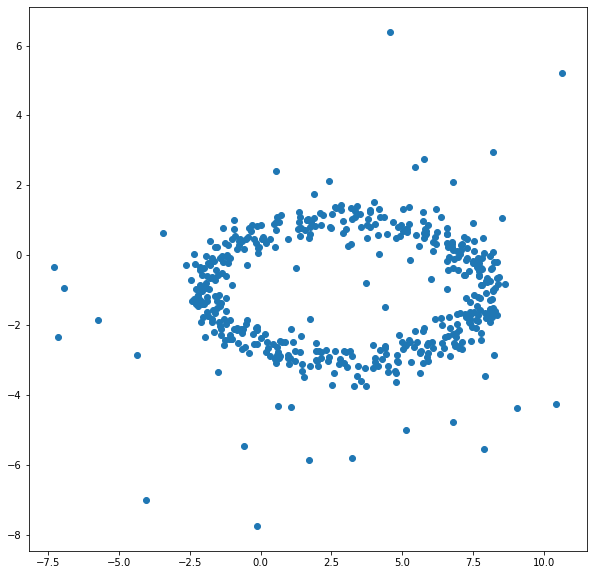

In [3]:
data = ellipse_data_gen(3, -1, 5, 2, 500, 0.9, 3)

plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1])

Функция получения центра окржности и радиуса по заданным 3 точкам

In [4]:
def get_circle(p1, p2, p3):
  c = (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2
  a = (p2[0] - p3[0])**2 + (p2[1] - p3[1])**2
  b = (p3[0] - p1[0])**2 + (p3[1] - p1[1])**2

  s = 2 * (a*b + b*c + c*a) - (a*a + b*b + c*c)

  p0 = np.array([((a*(b+c-a)*p1[0]) + (b*(c+a-b)*p2[0]) + (c*(a+b-c)*p3[0]))/s,
                 ((a*(b+c-a)*p1[1]) + (b*(c+a-b)*p2[1]) + (c*(a+b-c)*p3[1]))/s])

  ar = a**0.5
  br = b**0.5
  cr = c**0.5

  r = ar*br*cr / ((ar+br+cr) * (-ar+br+cr) * (ar-br+cr) * (ar+br-cr))**0.5

  return p0, r

Функция, реализуящая метод RANSAC для получения лучших параметров эллипса через 2 окружности (малую и большую)

In [5]:
def ellipse_ransac(data, iter_number=100, eps=0.05, min_inliners=10, center_shift_scale=10.0):
  # полуоси эллипса
  a = 0
  b = float('inf')
  best_score = float('inf')
  min_circle_inliers_count = data.shape[0]
  point_mean = np.mean(data, axis=0)

  # выполнение итераций указанное количество раз
  for i in range(iter_number):
    # вбросы и ошибка
    inliners = []
 
    # выбираем индексы 2-х точек из массива
    indexes = np.random.choice(data.shape[0], 3, replace=False)

    # получаем координаты выбранных точек
    p1, p2, p3 = data[indexes, :]

    # получаем центр и радиус окружности
    try:
      p0, r = get_circle(p1, p2, p3)
    except Exception as e:
      print("Could not generate Circle model. Error=%s \n" % (str(e)))
      continue

    # проверка на то, как сильно центр отклонен от срежней точки
    if np.sqrt((p0[0] - point_mean[0])**2 + (p0[1] - point_mean[1])**2) > eps*center_shift_scale:
      continue

    # проходимся по остальным точкам (суть как и в RANSAC для окружности)
    for p in data:
      if p in data[indexes, :]:
        continue

      p_r = math.sqrt((p[0]-p0[0])**2 + (p[1]-p0[1])**2)
      diff_r = math.fabs(p_r - r)

      if diff_r > eps:
        continue

      inliners.append(p)

    if len(inliners) > min_inliners:
        # если это бо'льша окружность
        if a < r:
          a = r
          max_circle_params = p0, r
          max_circle_points = p1, p2, p3
      
        # если это ме'ньшая окружность
        if b > r:
          b = r
          min_circle_params = p0, r
          min_circle_points = p1, p2, p3

  return max_circle_params, max_circle_points, min_circle_params, min_circle_points

Применение функции RANSAC для построение горизонтально ориентированного эллипса на сгенерированных точках сдобавлением шума

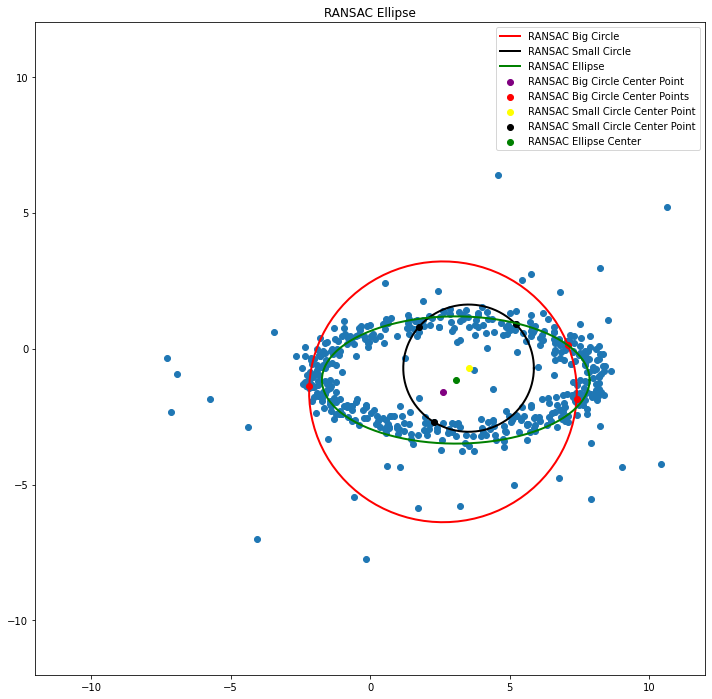

In [9]:
(p0_max, r_max), (p1_max, p2_max, p3_max), (p0_min, r_min), (p1_min, p2_min, p3_min) = ellipse_ransac(data=data, iter_number=100, eps=0.1, min_inliners=20, center_shift_scale=10)

angle = np.linspace(0, 2 * math.pi, 100)
points_mean = (p0_max+p0_min) / 2
ellipse_max = np.array([[p0_max[0] + r_max * math.cos(t), p0_max[1] + r_max * math.sin(t)] for t in angle])
ellipse_min = np.array([[p0_min[0] + r_min * math.cos(t), p0_min[1] + r_min * math.sin(t)] for t in angle])
ellipse = np.array([[points_mean[0] + r_max * math.cos(t), points_mean[1] + r_min * math.sin(t)] for t in angle])

plt.figure(figsize=(12, 12))
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.scatter(data[:, 0], data[:, 1])

plt.scatter(p0_max[0], p0_max[1], label='RANSAC Big Circle Center Point', color='purple')
plt.scatter(p1_max[0], p1_max[1], label='RANSAC Big Circle Center Points', color='red')
plt.scatter(p2_max[0], p2_max[1], color='red')
plt.scatter(p3_max[0], p3_max[1], color='red')

plt.scatter(p0_min[0], p0_min[1], label='RANSAC Small Circle Center Point', color='yellow')
plt.scatter(p1_min[0], p1_min[1], label='RANSAC Small Circle Center Point', color='black')
plt.scatter(p2_min[0], p2_min[1], color='black')
plt.scatter(p3_min[0], p3_min[1], color='black')

plt.scatter(points_mean[0], points_mean[1], label='RANSAC Ellipse Center', color='green')

plt.plot(ellipse_max.T[0], ellipse_max.T[1], label='RANSAC Big Circle', color='red', linewidth=2)
plt.plot(ellipse_min.T[0], ellipse_min.T[1], label='RANSAC Small Circle', color='black', linewidth=2)
plt.plot(ellipse.T[0], ellipse.T[1], label='RANSAC Ellipse', color='green', linewidth=2)

plt.legend()
plt.title('RANSAC Ellipse')
plt.savefig('RANSAC Ellipse.png')